# WSI zadanie 7 

Artur Kempiński 325168

python==3.11.6

numpy==1.24.3

matplotlib==3.8.0

In [ ]:
from matplotlib import pyplot as plt
import random
import numpy as np
import time
import gc

# Implementacja ogólna

In [ ]:
class Node:
    def __init__(self, name):
        self.name = name
        self.parents = []
        self.children = []

In [ ]:
class BayesNetwork:
    def __init__(self, structure, probabilities):
        self.nodes = []
        self.node_values = {}
        self.probabilities = probabilities
        self.initialize_structure(structure)

    def has_node(self, node_name):
        for node in self.nodes:
            if node.name == node_name:
                return True
        return False

    def get_node(self, node_name):
        for node in self.nodes:
            if node.name == node_name:
                return node
        return None

    def add_node(self, node):
        if not self.has_node(node):
            self.nodes.append(node)

    def add_parent_child_relationship(self, parent_node, child_node):
        if child_node not in parent_node.children:
            parent_node.children.append(child_node)
        if parent_node not in child_node.parents:
            child_node.parents.append(parent_node)

    def initialize_structure(self, structure):
        for node_name, relationships in structure.items():
            current_node = Node(node_name)
            self.add_node(current_node)
        for node_name, relationships in structure.items():
            current_node = self.get_node(node_name)
            for parent_name in relationships['Parents']:
                parent_node = self.get_node(parent_name)
                self.add_parent_child_relationship(parent_node, current_node)
            for child_name in relationships['Children']:
                child_node = self.get_node(child_name)
                self.add_parent_child_relationship(current_node, child_node)
            

In [ ]:
class GibbsSampler:
    def __init__(self, bayes_network, possible_values):
        self.bayes_network = bayes_network
        self.possible_values = possible_values
        self.counter = {}

    def run(self, evidences, query_variable, amount_of_iterations):  # (1)
        self.initialize_values(evidences, self.possible_values)
        self.initialize_counters(query_variable, self.possible_values)
        
        for _ in range(amount_of_iterations):
            node = self.generate_not_evidence_node(evidences)
            probabilities = self.calculate_conditional_probabilities(node)
            new_value = self.sample_value_accordring_to_dist(probabilities)  # (2)
            self.bayes_network.node_values[node.name] = new_value
            self.counter[(query_variable, self.bayes_network.node_values[query_variable])] += 1

        normalized = self.normalize(self.counter, amount_of_iterations)
        result = {}
        for possble_value in self.possible_values:
            result[possble_value] = normalized[(query_variable, possble_value)]
        
        return result

    def initialize_values(self, evidences, possible_values):
        for node in self.bayes_network.nodes:
            if node.name in evidences:
                self.bayes_network.node_values[node.name] = evidences[node.name]
            else:
                self.bayes_network.node_values[node.name] = random.choice(possible_values)

    def initialize_counters(self, query_variable, possible_values):
        for value in possible_values:
            self.counter[(query_variable, value)] = 0
            
    def generate_not_evidence_node(self, evidences):
        not_evidence_nodes = [node for node in self.bayes_network.nodes if node.name not in evidences]
        return random.choice(not_evidence_nodes)
    
    def calculate_conditional_probabilities(self, node):
        result = {}
        for value in self.possible_values:
            if node.parents:
                handler = [value]
                for parent in sorted(node.parents, key=lambda x: x.name):
                    handler.append(parent.name)
                    handler.append(self.bayes_network.node_values[parent.name])
                result[value] = self.get_nested_value(self.bayes_network.probabilities[node.name], handler)
            else:
                result[value] = self.bayes_network.probabilities[node.name][value]

            for child in sorted(node.children, key=lambda x: x.name):
                handler = [value]
                for parent in sorted(child.parents, key=lambda x: x.name):
                    handler.append(parent.name)
                    handler.append(self.bayes_network.node_values[parent.name])
                result[value] *= self.get_nested_value(self.bayes_network.probabilities[child.name], handler)
        return result

    def sample_value_accordring_to_dist(self, probabilities):
        return random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0]
    
    def normalize(self, counter, iterations: int):
        result = {}
        for value, count in counter.items():
            result[value] = count / iterations
        return result

    def get_nested_value(self, dictionary, keys):
        for key in keys:
            if isinstance(dictionary, dict) and key in dictionary:
                dictionary = dictionary[key]
            else:
                return None
        return float(dictionary)

* (1) 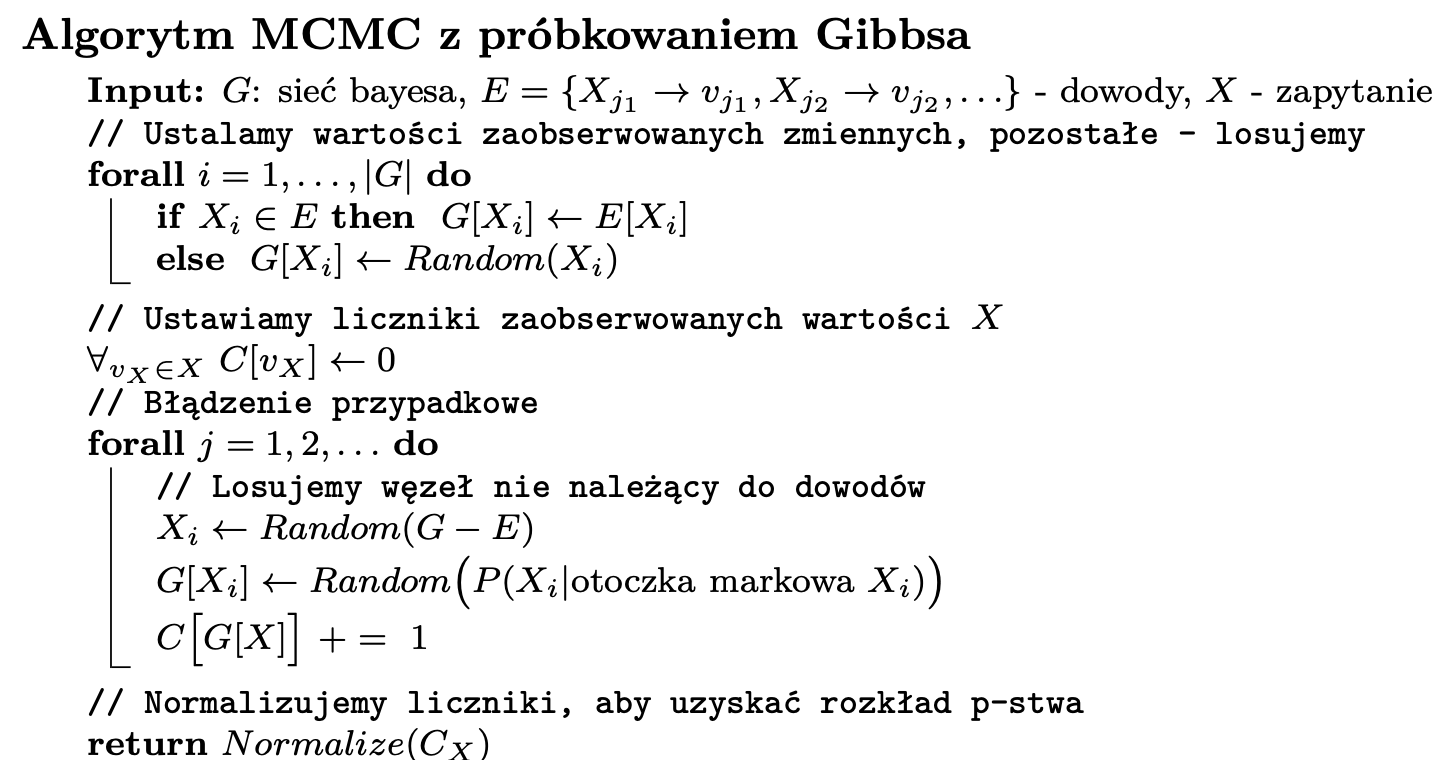

* (2) 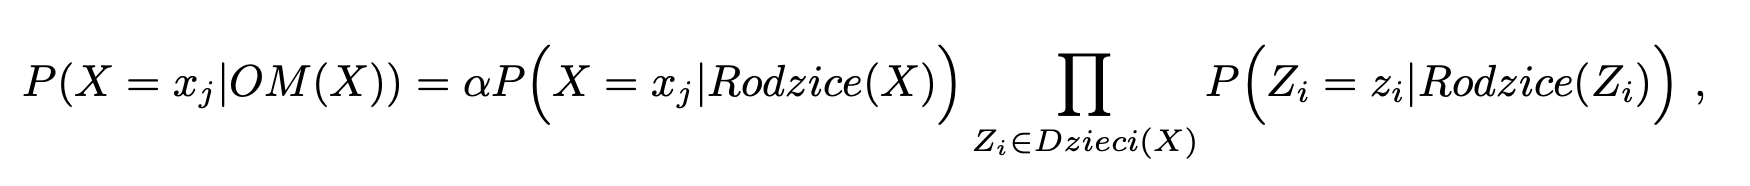

# Implementacja przykładu z wykładu

In [ ]:
probabilities = {
    "Burglary": {
        True: 0.01,
        False: 0.99
    },
    "Earthquake": {
        True: 0.02,
        False: 0.98
    },
    "Alarm": {
        True: {
            "Burglary": {
                True: {
                    "Earthquake": {
                        True: 0.95,
                        False: 0.94
                    }
                },
                False: {
                    "Earthquake": {
                        True: 0.29,
                        False: 0.001
                    }
                }
            }
        },
        False: {
            "Burglary": {
                True: {
                    "Earthquake": {
                        True: 0.05,
                        False: 0.06
                    }
                },
                False: {
                    "Earthquake": {
                        True: 0.71,
                        False: 0.999
                    }
                }
            }
        }
    },
    "John calls": {
        True: {
            "Alarm": {
                True: 0.9,
                False: 0.05
            }
        },
        False: {
            "Alarm": {
                True: 0.1,
                False: 0.95
            }
        }
    },
    "Magda calls": {
        True: {
            "Alarm": {
                True: 0.7,
                False: 0.01
            }
        },
        False: {
            "Alarm": {
                True: 0.3,
                False: 0.99
            }
        }
    }
}

In [ ]:
structure = {
        'Magda calls': {'Parents': ['Alarm'], 'Children': []},
        'Burglary': {'Parents': [], 'Children': ['Alarm']},
        'Alarm': {'Parents': ['Burglary', 'Earthquake'], 'Children': ['John calls', 'Magda calls']},
        'John calls': {'Parents': ['Alarm'], 'Children': []},
        'Earthquake': {'Parents': [], 'Children': ['Alarm']}
    }

In [ ]:
def init_network():
    return BayesNetwork(structure, probabilities)

In [ ]:
def run_for_query(query_variable, evidences, amount_of_iterations):
    possible_values = [True, False]
    network = init_network()
    sampler = GibbsSampler(network, possible_values)
    return sampler.run(evidences, query_variable, amount_of_iterations)

# Analiza

Przykładowe uruchomienie

In [ ]:
result = run_for_query('John calls', {'Burglary': True, 'Earthquake': False}, 10000)

print('Probability of John calling when there is a burglary and no earthquake: ', result[True])
print('Probability of John not calling when there is a burglary and no earthquake: ', result[False])

In [33]:
iterations = np.linspace(100, 100000, 100, dtype=int)

avg_true_results = []
avg_false_results = []

for iteration in iterations:
    true_results = []
    false_results = []
    for _ in range(20):
        result = run_for_query('John calls', {'Burglary': True, 'Earthquake': False}, iteration)
        true_results.append(result[True])
        false_results.append(result[False])
    avg_true_results.append(np.mean(true_results))
    avg_false_results.append(np.mean(false_results))

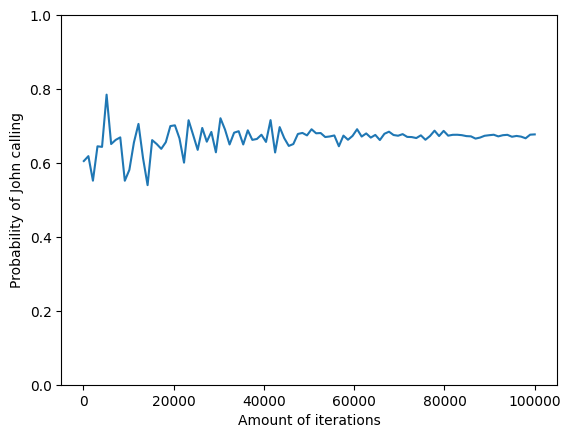

In [41]:
plt.plot(iterations, avg_true_results)
plt.xlabel('Amount of iterations')
plt.ylabel('Probability of John calling')
plt.ylim(0, 1)
plt.show()

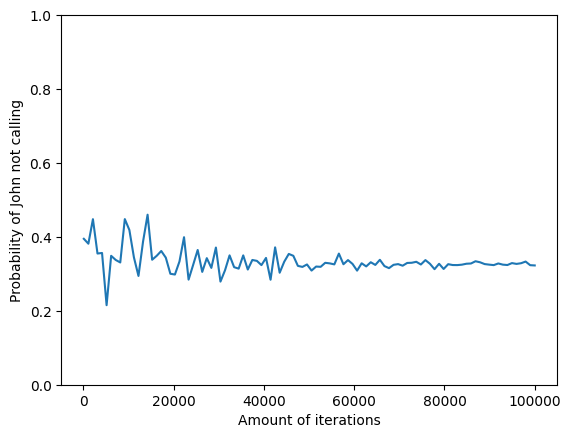

In [42]:
plt.plot(iterations, avg_false_results)
plt.xlabel('Amount of iterations')
plt.ylabel('Probability of John not calling')
plt.ylim(0, 1)
plt.show()

In [52]:
iterations = np.logspace(3, 6, 100, dtype=int)

avg_true_results = []
avg_false_results = []

for iteration in iterations:
    true_results = []
    false_results = []
    for _ in range(10):
        result = run_for_query('John calls', {'Burglary': True, 'Earthquake': False}, iteration)
        true_results.append(result[True])
        false_results.append(result[False])
    avg_true_results.append(np.mean(true_results))
    avg_false_results.append(np.mean(false_results))

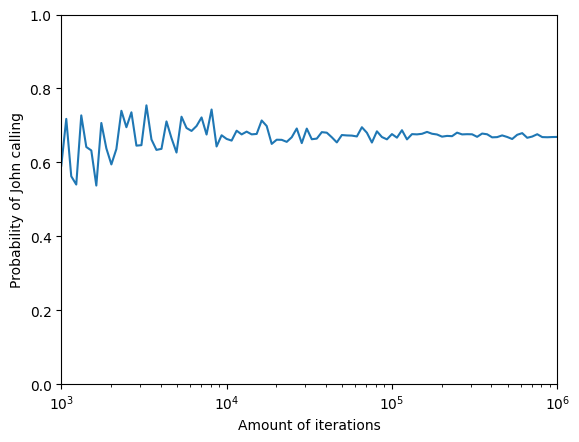

In [53]:
plt.plot(iterations, avg_true_results)
plt.xscale('log')
plt.xlabel('Amount of iterations')
plt.ylabel('Probability of John calling')
plt.ylim(0, 1)
plt.xlim(1000, 1000000)
plt.show()

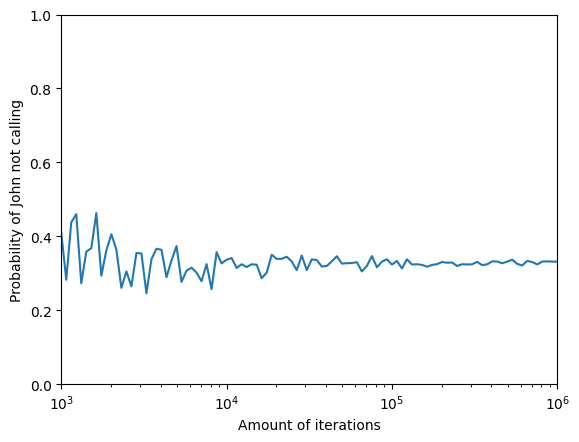

In [54]:
plt.plot(iterations, avg_false_results)
plt.xscale('log')
plt.xlabel('Amount of iterations')
plt.ylabel('Probability of John not calling')
plt.ylim(0, 1)
plt.xlim(1000, 1000000)
plt.show()

Postanowiłem wykonać wykresy zarówno w skali liniowej jak i logarytmicznej. Jak można zauważyć, wraz ze wzrostem liczby iteracji prawdopodobieństwo danego zdażenia dąży do konkretnej wartości, wnioskuje że jest to "prawdziwa" wartość prawdopodobieństwa tego zdarzenia.

Około ~50 000 iteracji wydaje się być optymalne dla uzyskania rozsądnych rezultatów.

In [39]:
def get_execution_time(iterations):
    gc.disable()
    start = time.time()
    run_for_query('John calls', {'Burglary': True, 'Earthquake': False}, iterations)
    end = time.time()
    gc.enable()
    return end - start

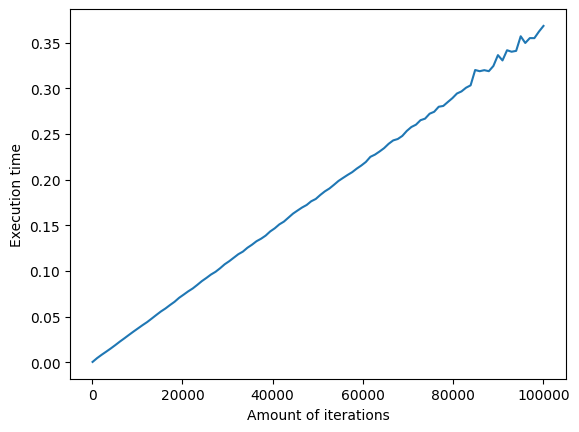

In [40]:
iterations = np.linspace(100, 100000, 100, dtype=int)

avg_execution_times = []

for iteration in iterations:
    execution_times = []
    for _ in range(10):
        execution_times.append(get_execution_time(iteration))
    avg_execution_times.append(np.mean(execution_times))
    
plt.plot(iterations, avg_execution_times)
plt.xlabel('Amount of iterations')
plt.ylabel('Execution time')
plt.show()

Czas wykonania algorytmu rośnie liniowo w stosunku do ilości iteracji. Ciężko mi wyciągnąć więcej wniosków na ten temat.